### Settings

In [1]:
import sys
import os
path = os.path.abspath("../../VecRepV3") 
sys.path.append(path)
print(path)

/home/jovyan/workspace-test1/VecRepV3


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, TensorDataset, Sampler, random_split, Dataset, Subset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random

from collections import defaultdict, Counter
from line_profiler import profile
from scipy.linalg import orthogonal_procrustes

import src.data_processing.ImageCalculations as imgcalc
import src.visualization.ImagePlots as imgplt
import src.helpers.ModelUtilities as models
import src.data_processing.Utilities as utils
import src.helpers.FilepathUtils as Futils
import src.data_processing.EmbeddingFunctions as embedfunc

from src.visualization import BFmethod
from functools import partial
from learnable_polyphase_sampling.learn_poly_sampling.layers import get_logits_model, PolyphaseInvariantDown2D, LPS
from learnable_polyphase_sampling.learn_poly_sampling.layers.polydown import set_pool

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
print(device)

/home/jovyan/miniconda3/envs/test/lib/python3.12/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


cpu


In [3]:
# ----------------------------------Image Input----------------------------------
IMAGE_TYPES = ["NbinMmax_ones", "Nbin", "triangles", "triangle_mean_subtracted"]

IMAGE_FILTERS = ["unique", "Nmax_ones", "one_island"]

IMAGE_PRODUCT_TYPES = ["ncc", "ncc_scaled"]

EMBEDDING_TYPES = ["pencorr_D"]

dimensions = 64
imageProductType = "ncc_scaled_-1"
overwrite = {"imgSet": False, "imgProd": False, "embedding": False}
weight = None
embeddingType = f"pencorr_{dimensions}"
k = 7
imageType = "MNIST"

model_directory = "model/all_model_dumps_1/LPS_models"

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

MNIST_data= torchvision.datasets.MNIST(root="/home/jovyan/workspace-test1/VecRepV3/data", train=False, transform=transform)
print(len(MNIST_data)) #Total unique images: 10000

random.seed(42)
sample_indices = random.sample(range(len(MNIST_data)), 500)
sampled_test_data = Subset(MNIST_data, sample_indices)

testSample = [
    sampled_test_data[i][0].squeeze().cpu().numpy().astype(np.float32)
    for i in range(len(sampled_test_data))
]
print(len(testSample))

10000
500


Label 0: 46 images
Label 1: 60 images
Label 2: 60 images
Label 3: 57 images
Label 4: 41 images
Label 5: 45 images
Label 6: 33 images
Label 7: 55 images
Label 8: 44 images
Label 9: 59 images


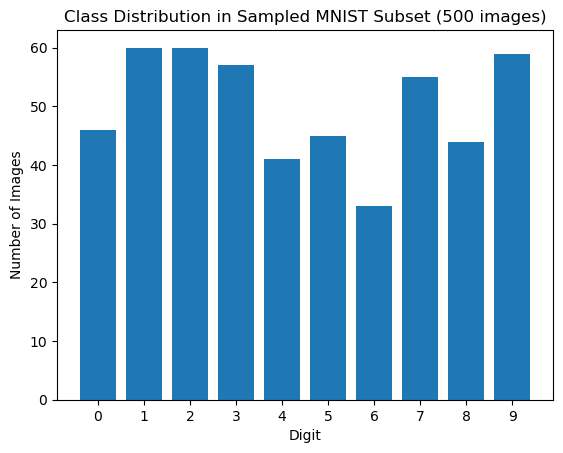

In [11]:
sampled_labels = [sampled_test_data[i][1] for i in range(len(sampled_test_data))]
label_counts = Counter(sampled_labels)

for label in sorted(label_counts):
    print(f"Label {label}: {label_counts[label]} images")

plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Digit')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Sampled MNIST Subset (500 images)')
plt.xticks(range(10))
plt.show()

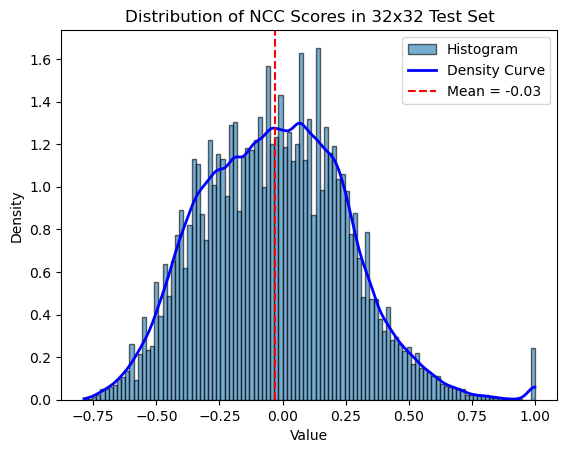

In [6]:
from scipy.stats import gaussian_kde
testSample = np.load('/home/jovyan/workspace-test1/VecRepV3/data/train_images_16x16.npy')
testSample = testSample[:500]
matrixG = imgcalc.get_matrixG(testSample, imageProductType)
upper_triangle = matrixG[np.triu_indices_from(matrixG, k=0)]

mean_val = np.mean(upper_triangle)
density = gaussian_kde(upper_triangle)
x_vals = np.linspace(min(upper_triangle), max(upper_triangle), 500)
density_vals = density(x_vals)
plt.hist(upper_triangle, bins='auto', edgecolor='black', density=True, alpha=0.6, label='Histogram')
plt.plot(x_vals, density_vals, color='blue', linewidth=2, label='Density Curve')
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean = {mean_val:.2f}')
plt.title("Distribution of NCC Scores in 32x32 Test Set")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


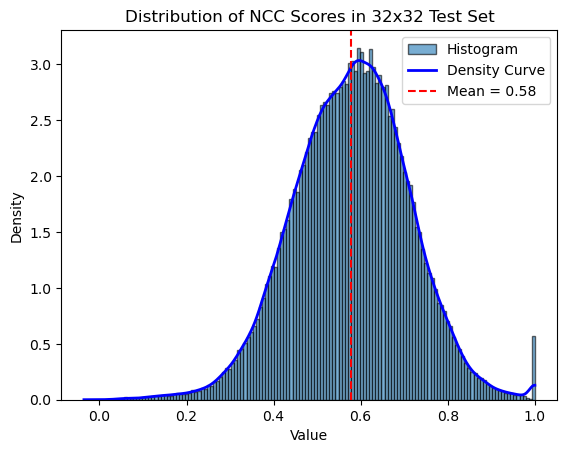

In [10]:
from scipy.stats import gaussian_kde


matrixG = imgcalc.get_matrixG(testSample, imageProductType)
upper_triangle = matrixG[np.triu_indices_from(matrixG, k=0)]

mean_val = np.mean(upper_triangle)
density = gaussian_kde(upper_triangle)
x_vals = np.linspace(min(upper_triangle), max(upper_triangle), 500)
density_vals = density(x_vals)
plt.hist(upper_triangle, bins='auto', edgecolor='black', density=True, alpha=0.6, label='Histogram')
plt.plot(x_vals, density_vals, color='blue', linewidth=2, label='Density Curve')
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean = {mean_val:.2f}')
plt.title("Distribution of NCC Scores in 32x32 Test Set")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


# Visualiation and Calculation using 2 random inputs

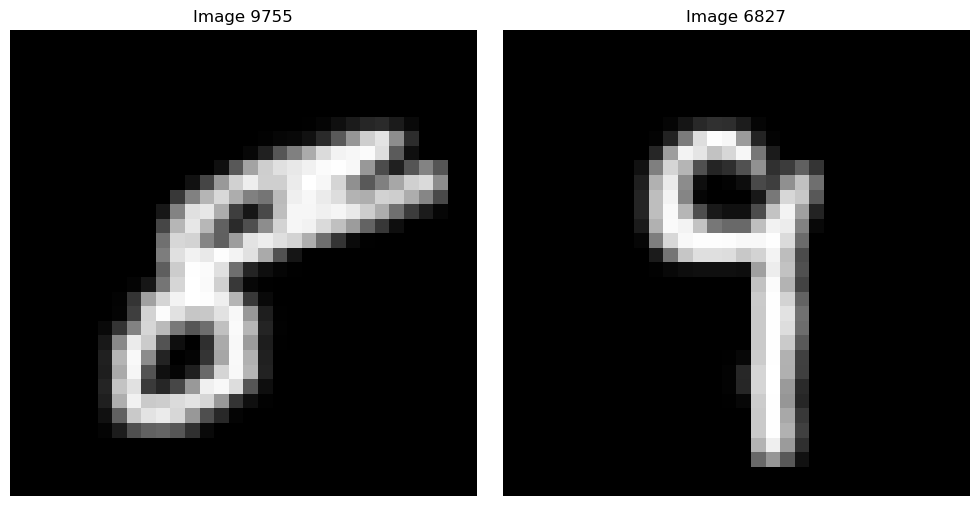

In [18]:
index1 = np.random.randint(len(testSample))
index2 = np.random.randint(len(testSample))
input1=testSample[index1][0].squeeze()
input2=testSample[index2][0].squeeze()

imgplt.plot_original_images(input1, input2, index1, index2)

# ------------------------- Preprocessing Dataset ------------------------
input_dataset = [
    testSample[i][0].unsqueeze(0).to(device).double()  #numpy -> tensor
    for i in range(len(testSample))
]

stacked_tensor = torch.stack(input_dataset)             
input_dataset = stacked_tensor.cpu().numpy()             
input_dataset = [torch.tensor(img).to(device).float() for img in input_dataset]  


In [4]:
model = models.SimpleCNN6(dimensions=dimensions, padding_mode='circular').to(device)
model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                                              f'best_model_MNIST_{imageType}_{dimensions}d_convlayer5.pt'), weights_only=True, map_location=torch.device('cpu')))
model.eval()

SimpleCNN6(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (lpd1): PolyphaseInvariantDown2D(
    (component_selection): LPS(
      (get_logits): LPSLogitLayersV2(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
        (relu): ReLU()
      )
    )
  )
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): LeakyReLU(negative_slope=0.1)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (lpd2): PolyphaseInvariantDown2D(
    (component_selection): LPS(
      (get_logits): LPSLogitLayersV2(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=c

### Visualisation of Loss score calculation -- Metric 1

In [ ]:
#----------------------Metric 1 - Loss Calculation-----------------
NCC_scaled_value = imgcalc.get_NCC_score(input1, input2)
print("\nLoss Calculation")
print("\nScaled NCC: ",NCC_scaled_value)

matrixG = imgcalc.get_matrixG(testSample, imageProductType)
matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)

model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]

dot_product_value = imgcalc.get_dp_score(model_vectors[index1], model_vectors[index2])

print("\nDot product value of model embeddings: ", dot_product_value.item())

train_loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
print("Loss: ", train_loss_value)

dot_product_value = imgcalc.get_dp_score(model_transformed[index1], model_transformed[index2])

print("\nDot product value of model transformed embeddings: ", dot_product_value.item())

train_loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
print("Loss: ", train_loss_value)

input1_transformed_normalised =  model_transformed[index1]/np.linalg.norm(model_transformed[index1].detach().cpu().numpy())
input2_transformed_normalised =  model_transformed[index2]/np.linalg.norm(model_transformed[index2].detach().cpu().numpy())
dot_product_value = imgcalc.get_dp_score(input1_transformed_normalised, input2_transformed_normalised)

print("\nDot product value of model transformed normalised embeddings: ", dot_product_value.item())

train_loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
print("Loss: ", train_loss_value)

dot_product_matrix = np.dot(matrixA.T, matrixA)
dot_product_value_Pencorr = dot_product_matrix[index1][index2]
difference = abs(dot_product_value_Pencorr - dot_product_value)

print("\nDot product value of BF Method embeddings: ", dot_product_value_Pencorr)

train_loss_value = imgcalc.get_loss_value(torch.tensor(dot_product_value_Pencorr), NCC_scaled_value) 
print("Loss: ", train_loss_value)
print("\nDifference in values of BF Method and Model Method: ", difference.item())

### Visualisation of KNN-IoU K score calculation -- Metric 2

In [ ]:
#----------------------Metric 2 - KNNIoU-----------------
print("----------------\nBrute Force Method -- KNN-IOU score\n----------------")
vectorb_bf1 = matrixG[index1]
vectorc_bf1 = imgcalc.get_vectorc_brute(index1, matrixA)
_, indices = imgplt.display_and_plot_results(vectorb_bf1, vectorc_bf1, "Brute Force", index1, k, testSample)

top_values_b_1, _ = imgcalc.get_top_scores(vectorb_bf1, len(indices), vectorc_bf1)
bottom_values_b_1, _ = imgcalc.get_bottom_scores(vectorb_bf1, len(indices), vectorc_bf1)
    
vectorb_bf2 = matrixG[index2]
vectorc_bf2 = imgcalc.get_vectorc_brute(index2, matrixA)
imgplt.display_and_plot_results(vectorb_bf2, vectorc_bf2, "Brute Force", index2, k, testSample)

top_values_b_2, _ = imgcalc.get_top_scores(vectorb_bf2, len(indices), vectorc_bf2)
bottom_values_b_2, _ = imgcalc.get_bottom_scores(vectorb_bf2, len(indices), vectorc_bf2)

print("----------------\nModel Method -- KNN-IOU score\n----------------")
vectorb_model1 = matrixG[index1]
vectorc_model1 = imgcalc.get_vectorc_model(index1, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model1, vectorc_model1, "Model", index1, k, testSample)

vectorb_model2 = matrixG[index2]
vectorc_model2 = imgcalc.get_vectorc_model(index2, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model2, vectorc_model2, "Model", index2, k, testSample)

print("----------------\nTransformed Model Method -- KNN-IOU score\n----------------")
input2_transformed_1 =  model_transformed[index1]
input2_transformed_2 =  model_transformed[index2]
vectorc_transformed_1 = []
vectorc_transformed_2 = []
for j in range(len(input_dataset)):
    input1_transformed =  model_transformed[j]
    dot_product_transformed = torch.sum(input1_transformed * input2_transformed_1, dim=1)
    vectorc_transformed_1.append(dot_product_transformed.detach().cpu().numpy().item())
    
    dot_product_transformed = torch.sum(input1_transformed * input2_transformed_2, dim=1)
    vectorc_transformed_2.append(dot_product_transformed.detach().cpu().numpy().item())

imgplt.display_and_plot_results(vectorb_model1, vectorc_transformed_1, "Model", index1, k, testSample)
imgplt.display_and_plot_results(vectorb_model2, vectorc_transformed_2, "Model", index2, k, testSample)

print("----------------\nTransformed Normalised Model Method -- KNN-IOU score\n----------------")
input2_transformed_normalised_1 =  model_transformed[index1]/np.linalg.norm(model_transformed[index1].detach().cpu().numpy())
input2_transformed_normalised_2 =  model_transformed[index2]/np.linalg.norm(model_transformed[index2].detach().cpu().numpy())
vectorc_transformed_normalised_1 = []
vectorc_transformed_normalised_2 = []
for j in range(len(input_dataset)):
    input1_transformed_normalised =  model_transformed[j]/np.linalg.norm(model_transformed[j].detach().cpu().numpy())
    dot_product_transformed_normalised = torch.sum(input1_transformed_normalised * input2_transformed_normalised_1, dim=1)
    vectorc_transformed_normalised_1.append(dot_product_transformed_normalised.detach().cpu().numpy().item())
    
    dot_product_transformed_normalised = torch.sum(input1_transformed_normalised * input2_transformed_normalised_2, dim=1)
    vectorc_transformed_normalised_2.append(dot_product_transformed_normalised.detach().cpu().numpy().item())

imgplt.display_and_plot_results(vectorb_model1, vectorc_transformed_normalised_1, "Model", index1, k, testSample)
imgplt.display_and_plot_results(vectorb_model2, vectorc_transformed_normalised_2, "Model", index2, k, testSample)

### Visualisation of Relative Squared Difference of **original** matrix and vector embedding -- Metric 3

In [ ]:
# -----------------------------Before transforming output embedding matrices-----------------------------
# ----------- Preprocessing dataset -------------
dim = 64
embeddingType = f"pencorr_{dim}"

model = models.SimpleCNN6(dimensions=dim, padding_mode='circular').to(device)
model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                 f'best_model_MNIST_{imageType}_{dim}d_convlayer5.pt'), weights_only=True))

model.eval()

model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_matrix = imgcalc.get_matrix_embeddings(input_dataset, model_vectors)

matrixG = imgcalc.get_matrixG(testSample, imageProductType)
matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
dot_product_matrix = np.dot(matrixA.T, matrixA)

######################################################
mean_squared_difference = imgcalc.get_MSE(matrixG, dot_product_matrix)
print("Mean Squared Difference of Matrices -- Pencorr (A'A) and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(matrixG, model_matrix.detach().cpu().numpy())
print("\nMean Squared Difference of of Matrices -- Model and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(dot_product_matrix, model_matrix.detach().cpu().numpy())
print("Mean Squared Difference of of Matrices -- Model and Pencorr (A'A):", mean_squared_difference)
    
print(f"\nPrinting matrices")
print(f"\nMatrix G: {matrixG}")
print(f"\nMatrix A'A (Pencorr): {dot_product_matrix}, {dot_product_matrix.shape}")
print(f"\nMatrix A'A (Model): {model_matrix.detach().cpu().numpy()}, {model_matrix.detach().cpu().numpy().shape}")

print(f"\nPrinting vectors")
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")

print(f"\nDifferences between vector embeddings")
mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_vectors[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Model: {mean_squared_difference}")

### Visualisation of Relative Squared Difference of **transformed** matrix and vector embedding using Orthogonal Procrustes -- Metric 3

In [ ]:
#-----------------After transforming output embedding matrices via Orthorgonal Procrustes ----------------
print(f"Difference between matrices")
model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
model_matrix_transformed = imgcalc.get_matrix_embeddings(input_dataset, model_transformed)

mean_squared_difference = imgcalc.get_MSE(matrixG, model_matrix_transformed.detach().cpu().numpy())
print("\nMean Squared Difference of Matrices -- Transformed Model and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(dot_product_matrix, model_matrix_transformed.detach().cpu().numpy())
print("Mean Squared Difference of Matrices -- Transformed Model and Pencorr (A'A):", mean_squared_difference)

print(f"\nPrinting matrices after transformation")
print(f"\nMatrix G: {matrixG}")
print(f"\nMatrix A'A (Pencorr): {dot_product_matrix}, {dot_product_matrix.shape}")
print(f"\nMatrix A'A (Transformed Model): {model_matrix_transformed}, error: {error_model}")

print(f"\nPrinting vectors ")
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
print(f"Embedding of image {index1} for Transformed Model: {model_transformed[index1]}")

print(f"\nDifferences between vector embeddings")
mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_transformed[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Transformed Model: {mean_squared_difference}")

mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_vectors[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Model: {mean_squared_difference}")

### Visualisation of Relative Squared Difference of **transformed normalised** vector embedding using Orthogonal Procrustes -- Metric 3

In [ ]:
#-----------------After normalising the transformed output embedding matrices via Orthorgonal Procrustes ----------------
print(f"Difference between matrices")
model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
model_matrix_transformed = imgcalc.get_matrix_embeddings(input_dataset, model_transformed)

print(f"\nPrinting vectors ")
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
print(f"Embedding of image {index1} for Transformed Normalised Model: {model_transformed[index1]/np.linalg.norm(model_transformed[index1].detach().cpu().numpy())}")

print(f"\nDifferences between vector embeddings")
mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_transformed[index1]/np.linalg.norm(model_transformed[index1].detach().cpu().numpy()))
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Transformed Normalised Model: {mean_squared_difference}")

mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_transformed[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Transformed Model: {mean_squared_difference}")

mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_vectors[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Model: {mean_squared_difference}")

### Visualisation of original vector embeddings of similar images across dimensions -- Metric 4

In [ ]:
#comparison with similar images before transforming output embedding matrices
# ----------- Preprocessing dataset -------------
matrixG = imgcalc.get_matrixG(testSample, imageProductType)
dimensions = [32, 64, 128, 256]
for dim in dimensions:
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN6(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_MNIST_{imageType}_{dim}d_convlayer5.pt'), weights_only=True))

    model.eval()

    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    mean_diff_dim_model = []
    mean_diff_dim_pencorr = []
    mean_values_dim_model = []
    mean_values_dim_pencorr = []
    for i in range(len(top_values_b_1)):
        top_1_index = top_values_b_1[i][0]
        # print(top_1_index)
        # print(f"\nPrinting vectors for index {index1}")
        # print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")    
        # print(f"Embedding of similar image {top_1_index} for Model: {model_vectors[top_1_index]}")
        # print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
        # print(f"\nEmbedding of similar image {top_1_index} for Pencorr (A'A): {matrixA[:,top_1_index]}")

        # print(f"\nDifferences between vector embeddings")
        mean_squared_difference = imgcalc.get_MSE(model_vectors[top_1_index].detach().cpu().numpy(), model_vectors[index1].detach().cpu().numpy())
        # print(f"Mean Squared Difference of Model between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_model.append(mean_squared_difference)
        mean_values_dim_model.append(abs(model_vectors[top_1_index].detach().cpu().numpy()).mean())
        
        mean_squared_difference = imgcalc.get_MSE(matrixA[:,top_1_index], matrixA[:,index1])
        # print(f"Mean Squared Difference of Pencorr (A'A) between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_pencorr.append(mean_squared_difference)
        mean_values_dim_pencorr.append(abs(matrixA[:,top_1_index]).mean())

    indices = [x[0] for x in top_values_b_1]
    print(indices)
    fig, axes = plt.subplots(2, 1, figsize=(8, 10))
    axes[0].bar(range(len(indices)), mean_diff_dim_model, color='blue', alpha=0.7, label="Mean Diff Dim Model")
    axes[0].set_xticks(range(len(indices)))
    axes[0].set_xticklabels(indices, rotation=45) 
    axes[0].set_ylabel("Mean Diff Dim Model")
    axes[0].set_title("Mean Diff Dim Model vs Top Values B 1")
    axes[0].legend()

    axes[1].bar(range(len(indices)), mean_diff_dim_pencorr, color='red', alpha=0.7, label="Mean Diff Dim Pencorr")
    axes[1].set_xticks(range(len(indices)))
    axes[1].set_xticklabels(indices, rotation=45) 
    axes[1].set_xlabel("Top Values B 1")
    axes[1].set_ylabel("Mean Diff Dim Pencorr")
    axes[1].set_title("Mean Diff Dim Pencorr vs Top Values B 1")
    plt.tight_layout()
    plt.show()
    
    imgplt.plot_score_distribution(mean_diff_dim_model, f"MSE of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_diff_dim_pencorr, f"MSE of Pencorr for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_model, f"Average value of embeddings of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_pencorr, f"Average value of embeddings of Pencorr for dimension {dim}")

### Visualisation of original vector embeddings of different images across dimensions -- Metric 4

In [ ]:
#comparison with different images
# ----------- Preprocessing dataset -------------
matrixG = imgcalc.get_matrixG(testSample, imageProductType)
dimensions = [32, 64, 128, 256]
for dim in dimensions:
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN6(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_MNIST_{imageType}_{dim}d_convlayer5.pt'), weights_only=True))

    model.eval()

    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    mean_diff_dim_model = []
    mean_diff_dim_pencorr = []
    mean_values_dim_model = []
    mean_values_dim_pencorr = []
    for i in range(len(bottom_values_b_1)):
        top_1_index = bottom_values_b_1[i][0]
        # print(top_1_index)
        # print(f"\nPrinting vectors for index {index1}")
        # print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")    
        # print(f"Embedding of similar image {top_1_index} for Model: {model_vectors[top_1_index]}")
        # print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
        # print(f"\nEmbedding of similar image {top_1_index} for Pencorr (A'A): {matrixA[:,top_1_index]}")

        # print(f"\nDifferences between vector embeddings")
        mean_squared_difference = imgcalc.get_MSE(model_vectors[top_1_index].detach().cpu().numpy(), model_vectors[index1].detach().cpu().numpy())
        # print(f"Mean Squared Difference of Model between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_model.append(mean_squared_difference)
        mean_values_dim_model.append(abs(model_vectors[top_1_index].detach().cpu().numpy()).mean())
        
        mean_squared_difference = imgcalc.get_MSE(matrixA[:,top_1_index], matrixA[:,index1])
        # print(f"Mean Squared Difference of Pencorr (A'A) between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_pencorr.append(mean_squared_difference)
        mean_values_dim_pencorr.append(abs(matrixA[:,top_1_index]).mean())

    indices = [x[0] for x in bottom_values_b_1]
    # print(indices)
    fig, axes = plt.subplots(2, 1, figsize=(8, 10))
    axes[0].bar(range(len(indices)), mean_diff_dim_model, color='blue', alpha=0.7, label="Mean Diff Dim Model")
    axes[0].set_xticks(range(len(indices)))
    axes[0].set_xticklabels(indices, rotation=45) 
    axes[0].set_ylabel("Mean Diff Dim Model")
    axes[0].set_title("Mean Diff Dim Model vs Top Values B 1")
    axes[0].legend()

    axes[1].bar(range(len(indices)), mean_diff_dim_pencorr, color='red', alpha=0.7, label="Mean Diff Dim Pencorr")
    axes[1].set_xticks(range(len(indices)))
    axes[1].set_xticklabels(indices, rotation=45) 
    axes[1].set_xlabel("Top Values B 1")
    axes[1].set_ylabel("Mean Diff Dim Pencorr")
    axes[1].set_title("Mean Diff Dim Pencorr vs Top Values B 1")
    plt.tight_layout()
    plt.show()
    
    imgplt.plot_score_distribution(mean_diff_dim_model, f"MSE of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_diff_dim_pencorr, f"MSE of Pencorr for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_model, f"Average value of embeddings of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_pencorr, f"Average value of embeddings of Pencorr for dimension {dim}")

# Visualiation and Calculation across dataset, across dimensions

## Metric 1 & 2: Loss and K-Score
### Visualisation of loss and k-score across dataset across dimensions

For dimension 32

NCC Interval		Average Loss
-0.1-0.0		0.0092 (4 samples)
-0.2--0.1		0.0000 (0 samples)
-0.3--0.2		0.0000 (0 samples)
-0.4--0.3		0.0000 (0 samples)
-0.5--0.4		0.0000 (0 samples)
-0.6--0.5		0.0000 (0 samples)
-0.7--0.6		0.0000 (0 samples)
-0.8--0.7		0.0000 (0 samples)
-0.9--0.8		0.0000 (0 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0127 (202 samples)
0.1-0.2		0.0167 (972 samples)
0.2-0.3		0.0197 (3566 samples)
0.3-0.4		0.0197 (16966 samples)
0.4-0.5		0.0189 (46692 samples)
0.5-0.6		0.0183 (70474 samples)
0.6-0.7		0.0171 (68144 samples)
0.7-0.8		0.0172 (32826 samples)
0.8-0.9		0.0205 (8336 samples)
0.9-1.0		0.0170 (1818 samples)


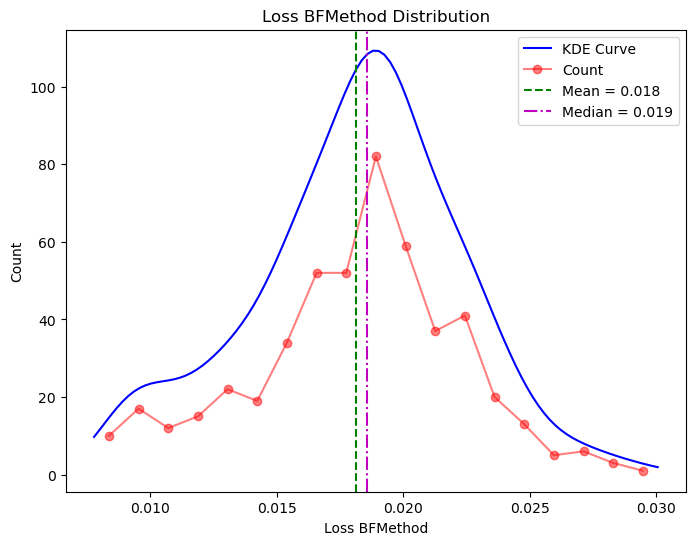

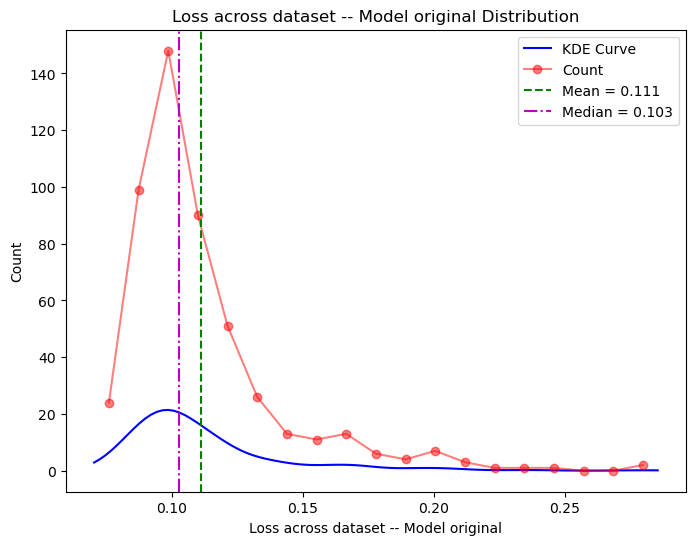

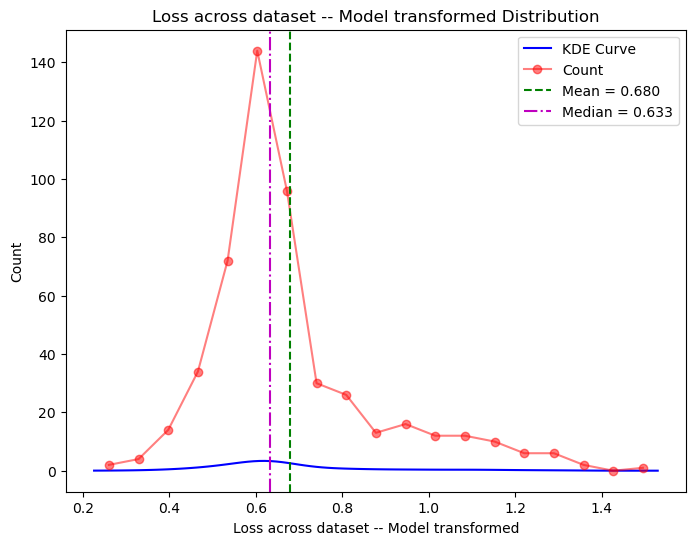

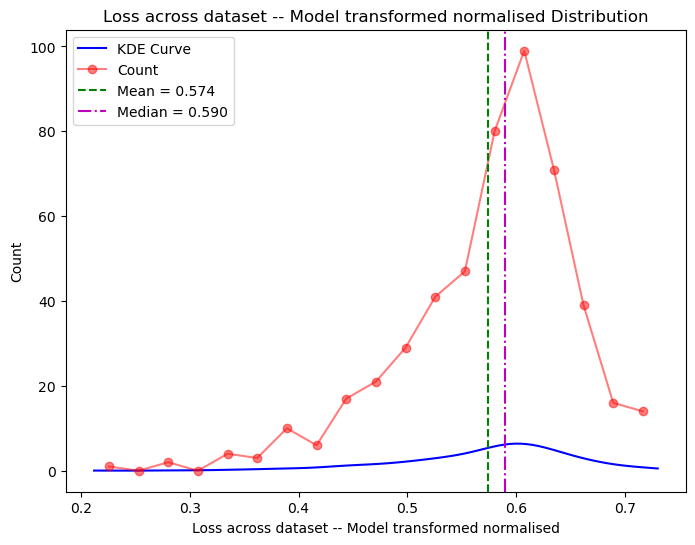

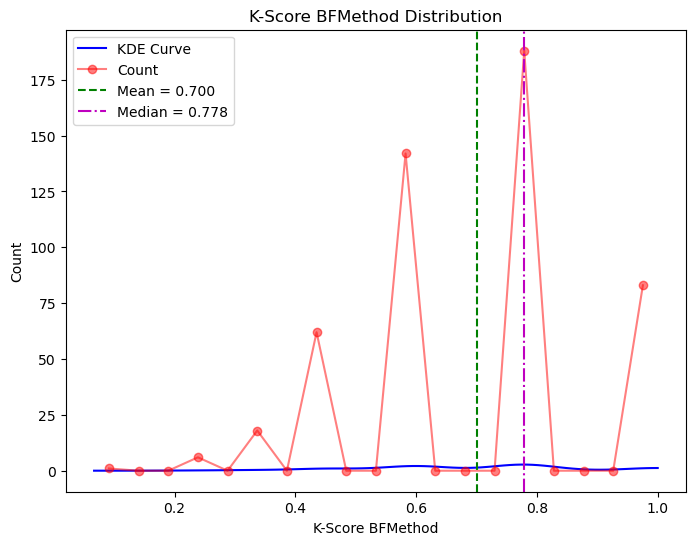

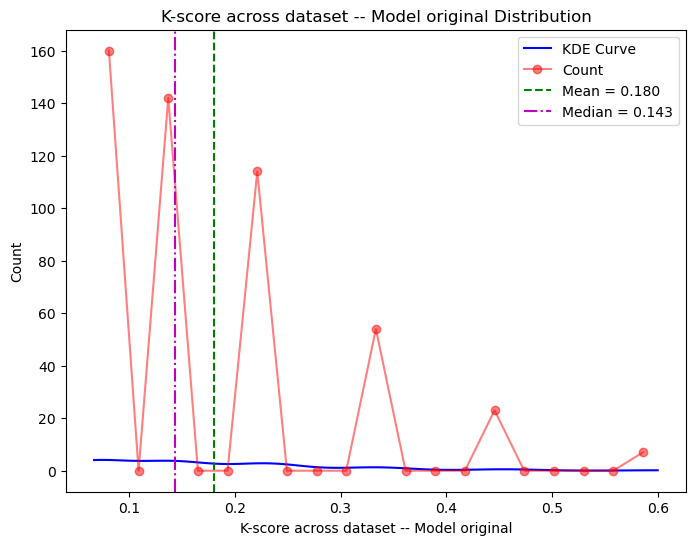

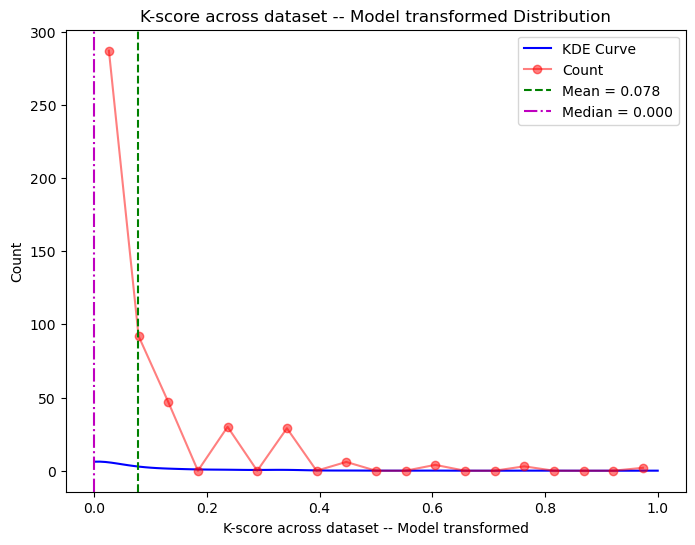

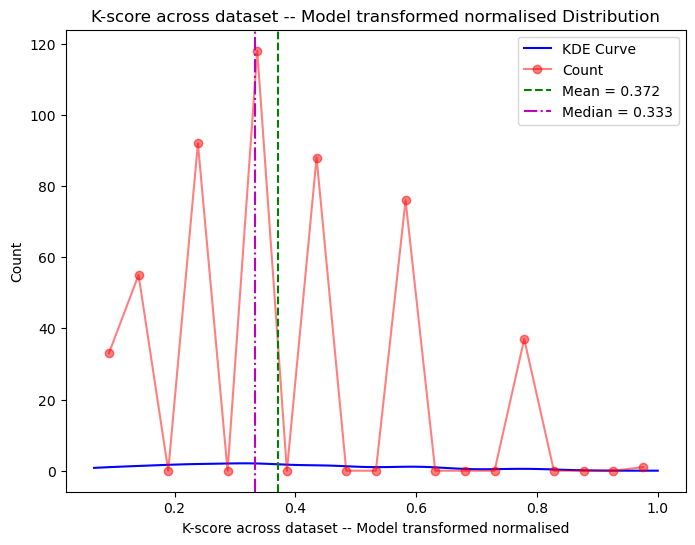

For dimension 64

NCC Interval		Average Loss
-0.1-0.0		0.0083 (4 samples)
-0.2--0.1		0.0000 (0 samples)
-0.3--0.2		0.0000 (0 samples)
-0.4--0.3		0.0000 (0 samples)
-0.5--0.4		0.0000 (0 samples)
-0.6--0.5		0.0000 (0 samples)
-0.7--0.6		0.0000 (0 samples)
-0.8--0.7		0.0000 (0 samples)
-0.9--0.8		0.0000 (0 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0098 (202 samples)
0.1-0.2		0.0119 (972 samples)
0.2-0.3		0.0135 (3566 samples)
0.3-0.4		0.0126 (16966 samples)
0.4-0.5		0.0118 (46692 samples)
0.5-0.6		0.0110 (70474 samples)
0.6-0.7		0.0100 (68144 samples)
0.7-0.8		0.0094 (32826 samples)
0.8-0.9		0.0101 (8336 samples)
0.9-1.0		0.0103 (1818 samples)


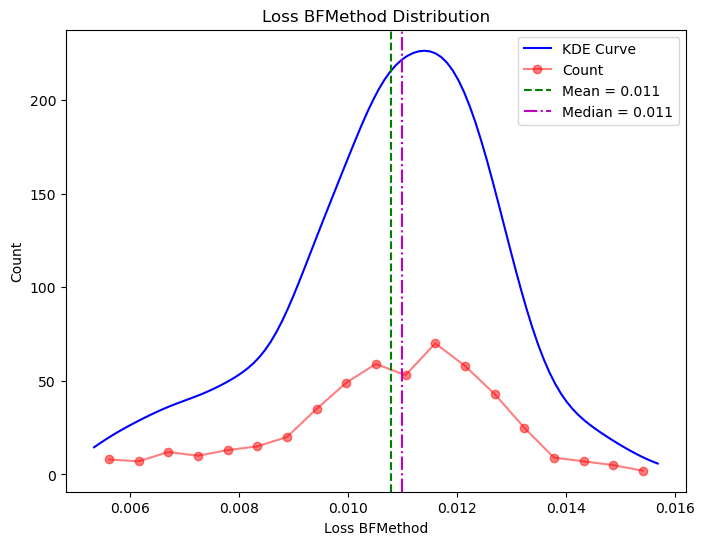

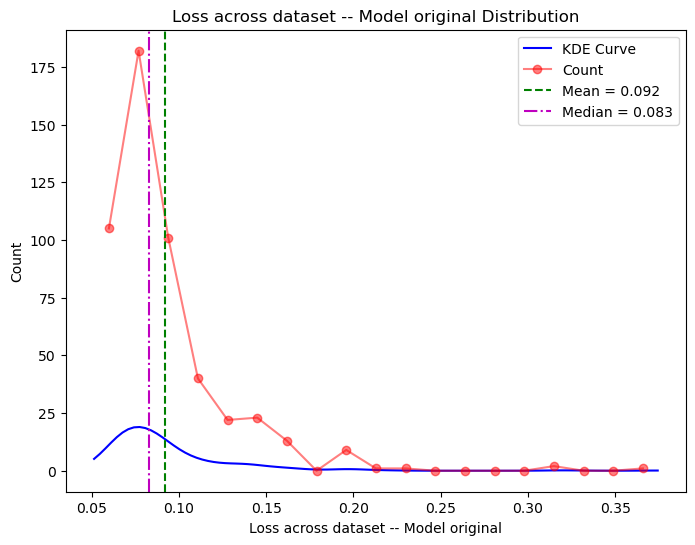

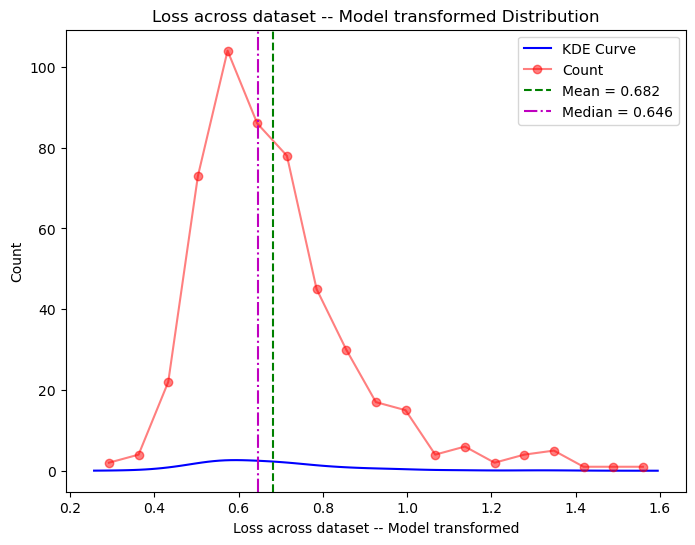

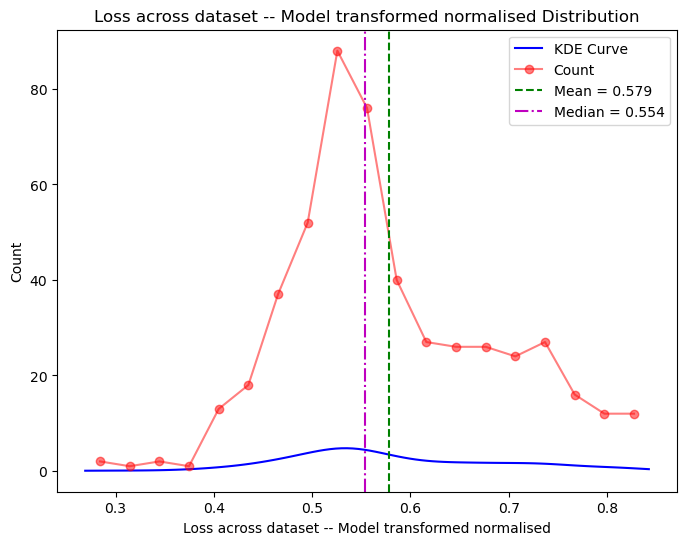

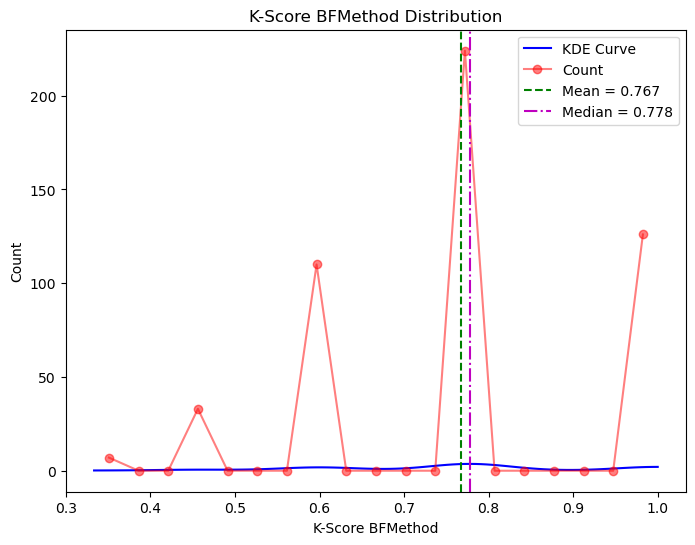

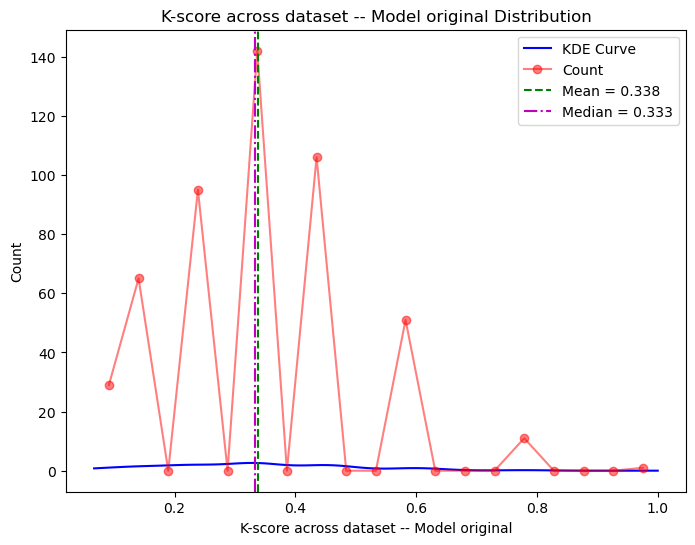

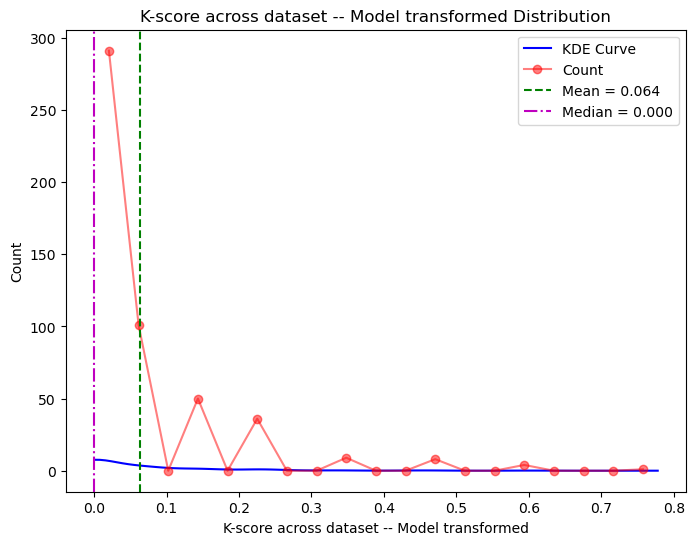

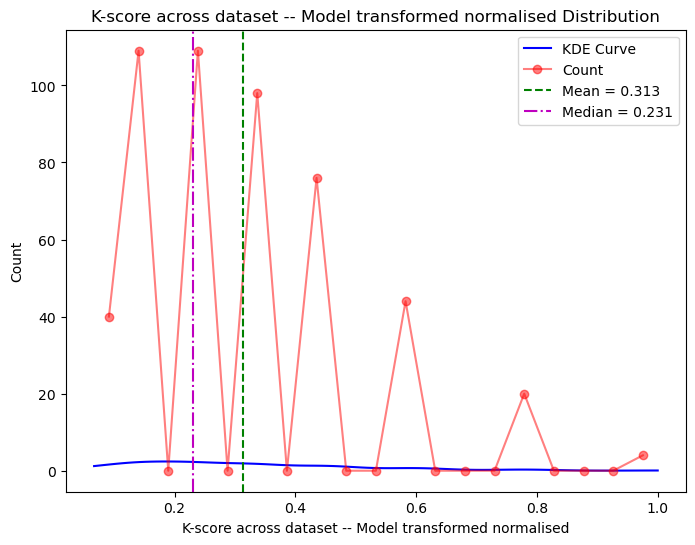

In [4]:
# ------------------------ Loss and Kscores of transformed embedding across dataset -----------------------------
dimensions = [32, 64]
losses_transformed_normalised = []
losses_transformed = []
losses_original = []
kscores_transformed_normalised = []
kscores_transformed = []
kscores_original = []
losses_BFMethod = []
kscores_BFMethod = []

input_dataset = []
testSample = []
num = len(sampled_test_data)
for i in range(len(sampled_test_data)):
    img_tensor = sampled_test_data[i][0] 
    input_dataset.append(img_tensor.unsqueeze(0).to(device).float())
    img_numpy = img_tensor.squeeze().cpu().numpy().astype(np.float32)
    testSample.append(img_numpy)

matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions: 
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN6(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_MNIST_{imageType}_{dim}d_convlayer5.pt'), weights_only=True, map_location=torch.device('cpu')))

    model.eval()

    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    dot_product_matrix = np.dot(matrixA.T, matrixA)

    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
    model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]

    kscore_transformed_normalised = []
    kscore_transformed = []
    kscore_original = []
    
    loss_original = []
    loss_transformed = []
    loss_transformed_normalised = []
    
    for i in range(num):
        vectorb = imgcalc.get_vectorb(i, testSample)

        input2_original = model_vectors[i]
        input2_transformed = model_transformed[i]
        #since after transformation, its not a unit vector
        input2_transformed_normalised =  model_transformed[i]/np.linalg.norm(model_transformed[i].detach().cpu().numpy())
        vectorc_original = []
        vectorc_transformed = []
        vectorc_transformed_normalised = []

        loss_value_transformed_normalised = []
        loss_value_transformed = []
        loss_value_original = []
        for j in range(num):
            input1_original = model_vectors[j]
            #since after transformation, its not a unit vector
            input1_transformed = model_transformed[j]
            input1_transformed_normalised =  model_transformed[j]/np.linalg.norm(model_transformed[j].detach().cpu().numpy())

            dot_product_orignal = torch.sum(input1_original * input2_original, dim=1)
            dot_product_transformed = torch.sum(input1_transformed * input2_transformed, dim=1)
            dot_product_transformed_normalised = torch.sum(input1_transformed_normalised * input2_transformed_normalised, dim=1)

            vectorc_original.append(dot_product_orignal.detach().cpu().numpy().item())
            vectorc_transformed.append(dot_product_transformed.detach().cpu().numpy().item())
            vectorc_transformed_normalised.append(dot_product_transformed_normalised.detach().cpu().numpy().item())

            NCC_scaled_value = imgcalc.get_NCC_score(testSample[i], testSample[j])

            loss_value = imgcalc.get_loss_value(dot_product_orignal, NCC_scaled_value) 
            loss_value_original.append(loss_value)

            loss_value = imgcalc.get_loss_value(dot_product_transformed, NCC_scaled_value) 
            loss_value_transformed.append(loss_value)

            loss_value = imgcalc.get_loss_value(dot_product_transformed_normalised, NCC_scaled_value) 
            loss_value_transformed_normalised.append(loss_value)

        average_loss_original = sum(loss_value_original) / len(loss_value_original)
        average_loss_transformed = sum(loss_value_transformed) / len(loss_value_transformed)
        average_loss_transformed_normalised = sum(loss_value_transformed_normalised) / len(loss_value_transformed_normalised)

        loss_original.append(average_loss_original)
        loss_transformed.append(average_loss_transformed)
        loss_transformed_normalised.append(average_loss_transformed_normalised)

        kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc_original, k)
        kscore_original.append(kscore)

        kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc_transformed, k)
        kscore_transformed.append(kscore)

        kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc_transformed_normalised, k)
        kscore_transformed_normalised.append(kscore)
            
    kscore_BFMethod, loss_BFMethod, _ = imgcalc.kscore_loss_evaluation_brute(testSample, matrixA, matrixG, k)
    
    imgplt.plot_score_distribution(loss_BFMethod, "Loss BFMethod")
    imgplt.plot_score_distribution(loss_original, "Loss across dataset -- Model original")
    imgplt.plot_score_distribution(loss_transformed, "Loss across dataset -- Model transformed")
    imgplt.plot_score_distribution(loss_transformed_normalised, "Loss across dataset -- Model transformed normalised")
    imgplt.plot_score_distribution(kscore_BFMethod, "K-Score BFMethod")
    imgplt.plot_score_distribution(kscore_original, "K-score across dataset -- Model original")
    imgplt.plot_score_distribution(kscore_transformed, "K-score across dataset -- Model transformed")
    imgplt.plot_score_distribution(kscore_transformed_normalised, "K-score across dataset -- Model transformed normalised")
    
    losses_transformed_normalised.append(np.mean(loss_transformed_normalised))
    losses_transformed.append(np.mean(loss_transformed))
    losses_original.append(np.mean(loss_original))
    losses_BFMethod.append(np.mean(loss_BFMethod))
    kscores_transformed_normalised.append(np.mean(kscore_transformed_normalised))
    kscores_transformed.append(np.mean(kscore_transformed))
    kscores_original.append(np.mean(kscore_original))
    kscores_BFMethod.append(np.mean(kscore_BFMethod))

In [ ]:
print(f"BFMethod: Loss and Kscores")
print("Kscores: ",kscores_BFMethod, np.argmax(kscores_BFMethod))
print("Losses: ",losses_BFMethod, np.argmin(losses_BFMethod))

print(f"\nOriginal Model: Loss and Kscores")
print("Kscores: ",kscores_original, np.argmax(kscores_original))
print("Losses: ",losses_original, np.argmin(losses_original))

print(f"\nTransformed Model: Loss and Kscores")
print("Kscores: ",kscores_transformed, np.argmax(kscores_transformed))
print("Losses: ",losses_transformed, np.argmin(losses_transformed))

print(f"\nTransformed Normalized Model: Loss and Kscores")
print("Kscores: ",kscores_transformed_normalised, np.argmax(kscores_transformed_normalised))
print("Losses: ",losses_transformed_normalised, np.argmin(losses_transformed_normalised))

## Metric 3: Relative Squared Difference between vector embeddings
### Visualisation of Relative Squared Difference between vector embeddings, of original and transformed model using Orthogonal Procrustes, and Pencorr embeddings across dataset across dimensions

In [ ]:
# ------------------------ MSE of embedding across dimensions across dataset -----------------------------
MSD_transformed_normalised = []
MSD_transformed = []
MSD_original = []
dimensions = [32, 64, 128, 256, 512]    
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:    
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN6(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_MNIST_{imageType}_{dim}d_convlayer5.pt'), weights_only=True))

    model.eval()
    
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    dot_product_matrix = np.dot(matrixA.T, matrixA)
    
    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
    model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
    
    # find a fair way to compare across the dimensions,
        # maybe can experiment with the different angles \
    MSE_transformed_normalised = []
    MSE_transformed = []
    MSE_original = []
    
    print(f"\nMSE between vector embeddings of dimension {dim} for Pencorr (A) and Models:")   
    for i in range(num):
        normalized_embedding = (model_transformed[i]/np.linalg.norm(model_transformed[i].detach().cpu().numpy())).detach().cpu().numpy()
        mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], normalized_embedding)
        #print(f"Original matrix of Index {i}: {mean_squared_difference}")
        MSE_transformed_normalised.append(mean_squared_difference)
        
        mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], model_transformed[i].detach().cpu().numpy())
        #print(f"Transformed matrix of Index {i}: {mean_squared_difference}")
        MSE_transformed.append(mean_squared_difference)

        mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], model_vectors[i].detach().cpu().numpy())
        #print(f"Original matrix of Index {i}: {mean_squared_difference}")
        MSE_original.append(mean_squared_difference)
    
    MSD_transformed_normalised.append(np.mean(MSE_transformed_normalised))                                              
    MSD_transformed.append(np.mean(MSE_transformed))
    MSD_original.append(np.mean(MSE_original))
    imgplt.plot_score_distribution(MSE_transformed_normalised, f"MSE of Transformed Normalised Model")                                              
    imgplt.plot_score_distribution(MSE_transformed, f"MSE of Transformed Model")
    imgplt.plot_score_distribution(MSE_original, f"MSE of Original Model")

In [ ]:
print("RSD Original Model: ", MSD_original, np.argmin(MSD_original))
print("RSD Transformed Model: ", MSD_transformed, np.argmin(MSD_transformed))
print("RSD Transformed Normalised Model: ", MSD_transformed_normalised, np.argmin(MSD_transformed_normalised))

## Metric 4: F1 Score
### Calculation of F1 Score across dimension using original vector embeddings and Pencorr embeddings

In [ ]:
#For model method F1 score calculation per dimension K
dimensions = [32, 64, 128, 256, 512]
f1_score = []
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:    
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN6(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_MNIST_{imageType}_{dim}d_convlayer5.pt'), weights_only=True, map_location=torch.device('cpu')))

    model.eval()
    f1_index = []
    
    tp_index = []
    fp_index = []
    tn_index = []
    fn_index = []
    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    
    #matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    for i in range(num):
        top_values_b_1, _ = imgcalc.get_top_scores(matrixG[i], k,  print_results=False)
        top_1_index = top_values_b_1[-1][0]
        indices = [x[0] for x in top_values_b_1]
        #print(i, indices)
        MSD_threshold = imgcalc.get_MSE(model_vectors[i].detach().cpu().numpy(), model_vectors[top_1_index].detach().cpu().numpy())
        
        TP, TN, FP, FN = 0, 0, 0, 0
        
        for j in range(num):
            mean_squared_difference = imgcalc.get_MSE(model_vectors[i].detach().cpu().numpy(), model_vectors[j].detach().cpu().numpy())
            predicted = mean_squared_difference <= MSD_threshold
            actual = j in indices

            if predicted and actual:
                TP += 1
            elif predicted and not actual:
                FP += 1
            elif not predicted and actual:
                FN += 1
            elif not predicted and not actual:
                TN += 1
    
        #print(TP, TN, FP, FN)
        tp_index.append(TP)
        fp_index.append(FP)
        tn_index.append(TN)
        fn_index.append(FN)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1 = f1*100
        f1_index.append(f1)

    
    average_f1_dim = np.mean(f1_index)
    f1_score.append(average_f1_dim)
    print(np.mean(tp_index), np.mean(fp_index), np.mean(tn_index), np.mean(fn_index))
    print(f"F1 Score: {average_f1_dim:.4f} for dimension {dim}")

In [ ]:
#For BFMEthod F1 score calculation per dimension K
dimensions = [32, 64, 128, 256, 512]
f1_score = []
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:    
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    # model = models.SimpleCNN3(dimensions=dim, padding_mode='circular').to(device)
    # model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
    #                  f'best_model_{imageType}_{dim}d_convlayer2.pt'), weights_only=True, map_location=torch.device('cpu')))

    # model.eval()
    f1_index = []
    
    tp_index = []
    fp_index = []
    tn_index = []
    fn_index = []
    #model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    for i in range(num):
        top_values_b_1, _ = imgcalc.get_top_scores(matrixG[i], k,  print_results=False)
        top_1_index = top_values_b_1[-1][0]
        indices = [x[0] for x in top_values_b_1]
        #print(i, indices)
        MSD_threshold = imgcalc.get_MSE(matrixA[:,i], matrixA[:,top_1_index])
        
        TP, TN, FP, FN = 0, 0, 0, 0
        
        for j in range(num):
            mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], matrixA[:,j])
            predicted = mean_squared_difference <= MSD_threshold
            actual = j in indices

            if predicted and actual:
                TP += 1
            elif predicted and not actual:
                FP += 1
            elif not predicted and actual:
                FN += 1
            elif not predicted and not actual:
                TN += 1
    
        #print(TP, TN, FP, FN)
        tp_index.append(TP)
        fp_index.append(FP)
        tn_index.append(TN)
        fn_index.append(FN)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1 = f1*100
        f1_index.append(f1)

    
    average_f1_dim = np.mean(f1_index)
    f1_score.append(average_f1_dim)
    print(np.mean(tp_index), np.mean(fp_index), np.mean(tn_index), np.mean(fn_index))
    print(f"F1 Score: {average_f1_dim:.4f} for dimension {dim}")

# Obtaining the optimal dimension using 4 different metrics above

In [ ]:
from collections import Counter
dimensions = [32, 64, 128, 256, 512]


metric1 = np.argmax(kscores_original)
metric2 = np.argmin(losses_original)
metric3A = np.argmin(MSD_original)
metric4 = np.argmax(f1_score)

metrics = [
    dimensions[metric1],
    dimensions[metric2],
    dimensions[metric3A],
    dimensions[metric4]
]

optimal_dim = Counter(metrics).most_common(1)[0][0]
print("Optimal Dimension:", optimal_dim)

### Using normalized embedding validation loss to determine optimal dimension.
#### Existing strategies for the selection of the embedding dimension rely on performance maximization in downstream tasks.

In [ ]:
def find_optimal_dim(losses, eps=0.05):  
    """
    Finds the optimal dimension based on the embedding loss function.

    :param losses: Dictionary {dimension: loss value}
    :param eps: Threshold percentage (default 0.05)
    :return: The optimal dimension
    """
    L_inf = min(losses.values())

    for d in sorted(losses.keys()): 
        if L_inf == 0 or (losses[d] - L_inf) / L_inf <= eps:  
            return d  

    return max(losses.keys()) 

losses = {8: 0.17436, 16: 0.10059, 32: 0.08990, 64: 0.09155, 128: 0.09328, 256: 0.0636}
optimal_dim = find_optimal_dim(losses)
print("Optimal Dimension:", optimal_dim)

In [ ]:
# -------------- for debugging -----------------
tolerance = 1e-6
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

rank = np.linalg.matrix_rank(matrixG)
print("Rank of the matrixG:", rank)

nDim = 64
# original image product matrix not PSD, after transformation,
matrixGprime = embedfunc.pencorr(matrixG, nDim) #reduce matrixG rank from image set size to nDim

print("g pirme")
rank = np.linalg.matrix_rank(matrixGprime) #156
''' 
given 753 unique training samples, rank of matrixG is by right 753 
ndim 512: rank of g' = 120, 120 positive eigenvalues for g', 380 positive eigenvalues for g
ndim 256: rank of g' = 120, 120 positive eigenvalues for g', 380 positive eigenvalues for g
ndim 64: rank of g' = 64, 64 positive eigenvalues for g', 380 positive eigenvalues for g

somewhere in the algorithm, it is coded such that pencorr striaghtaway finds the optimum rank of a matrix and minimises it
once rank is minimised to its optimum, the number of positive eigenvalues is only that number.
unless we set nDim < rank, we cannot change the number of positive eigenvalues.
this overall limits the number of dimensions we can test. 

essentially, since rank of g' determines the vector space formed by the rows and columns (linearly independent rows or columns in matrix),
the rank of a matrix is the number of non-zero eigenvalues of a matrix, which is why limiting the rank of the matrix to 120 only give
120 non-zero elements in our embedding dimension. 
'''
print("Rank of the matrixG':", rank)
eigenvalues, eigenvectors = np.linalg.eig(matrixGprime)
print(matrixGprime.shape) #753x753
print(eigenvalues.shape) #753
print(eigenvectors.shape) #753x753
num_positive_eigenvalues = np.sum(eigenvalues > tolerance) 
print("Number of eigenvalues greater than tolerance:", num_positive_eigenvalues)

matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]} {matrixA.shape} {matrixA[:,index1].size}")
count_not_close_to_zero = np.sum(np.abs(matrixA[:,index1]) > tolerance)
print("Number of elements not close to tolerance 1e-5:", count_not_close_to_zero)

count_to_zero = np.sum(np.abs(matrixA[:,index1]) > 0)
print("Number of elements not close to 0:", count_to_zero)

print("g")
eigenvalues, eigenvectors = np.linalg.eig(matrixG)
print(matrixG.shape) #753x753
print(eigenvalues.shape) #753
print(eigenvectors.shape)
num_positive_eigenvalues = np.sum(eigenvalues > tolerance) #380 ????????
print("Number of eigenvalues greater than tolerance:", num_positive_eigenvalues)